# Release Notes

上一个版本：`3.5-FE-???`

主要变化：
	
    1. 在所有时候，只删除null率在0.90以上的列；
    2. 进行异常值分析，如果异常值多于0.02的列，需要进行分箱；
    3. 只对除类别类型以外的变量进行传说中的归一化。类别型的不做归一化。

季度3,4皆用。

一定要注意，如果要排除某些列，一定要保证被排除的列必须相同。

# Setting working directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/XiamenIntlBank')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/XiamenIntlBank'

Go to this place for original dataset: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl/originalDataset'`

In [ ]:
## 安装catboost和lightgbm。
## catboost耗费显存极大，但是飞快；lightgbm好像不是那么的方便，gpu使用不起来。
# !pip install catboost

# !pip install featuretools

# Importing libraries and load datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, tqdm, re, random, warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, cohen_kappa_score
from collections import Counter, defaultdict
import tensorflow as tf
import featuretools

from scipy.stats import chi
from pandas import DataFrame,Series
import scipy

# Rudimentary processing

Like encoding some object type data

## Load dataset

In [2]:
data_train_3 = pd.read_csv('preprocessedData/quarter3_merged-validLabels.csv')
data_train_4 = pd.read_csv('preprocessedData/quarter4_merged-validLabels.csv')

data_test_a = pd.read_csv('preprocessedData/quarter1_merged-validUsers.csv')

## Combine the `featuretools` data

In [3]:
def getNewlyGeneratedFeaturetoolsFeature(directory):
    counter = 0
    newFeatures = pd.DataFrame()
    custNoCol = pd.DataFrame()
    for etyId in ["aum_m", "behavior_m", "cunkuan_m", "big_event", ]:
        for agg in ["sum", "max", "mode", "min", "count", "num_unique", "mean", "percent_true", "std", "skew", ]: 
            counter += 1
            print(f"{etyId}-{agg}.csv", counter)
            features = pd.read_csv(f"preprocessedData/{directory}/{etyId}-{agg}.csv")
            custNoCol = features[["cust_no"]]
            ## 把原始的Ixx列都删掉，然后和原列整合
            features.drop(
                [col for col in features.columns if re.search("^I\d+$", col) != None] + ["cust_no"], 
                axis = 1, 
                inplace=True
            )
            newFeatures = pd.concat([newFeatures, features], axis=1)
    newFeatures = pd.concat([custNoCol, newFeatures], axis=1)
    return newFeatures

newFeatures_q3 = getNewlyGeneratedFeaturetoolsFeature("featuretools-agg-q3-scheme1")
newFeatures_q4 = getNewlyGeneratedFeaturetoolsFeature("featuretools-agg-q4-scheme1")
newFeatures_q1 = getNewlyGeneratedFeaturetoolsFeature("featuretools-agg-q1-scheme1")

aum_m-sum.csv 1
aum_m-max.csv 2
aum_m-mode.csv 3
aum_m-min.csv 4
aum_m-count.csv 5
aum_m-num_unique.csv 6
aum_m-mean.csv 7
aum_m-percent_true.csv 8
aum_m-std.csv 9
aum_m-skew.csv 10
behavior_m-sum.csv 11
behavior_m-max.csv 12
behavior_m-mode.csv 13
behavior_m-min.csv 14
behavior_m-count.csv 15
behavior_m-num_unique.csv 16
behavior_m-mean.csv 17
behavior_m-percent_true.csv 18
behavior_m-std.csv 19
behavior_m-skew.csv 20
cunkuan_m-sum.csv 21
cunkuan_m-max.csv 22
cunkuan_m-mode.csv 23
cunkuan_m-min.csv 24
cunkuan_m-count.csv 25
cunkuan_m-num_unique.csv 26
cunkuan_m-mean.csv 27
cunkuan_m-percent_true.csv 28
cunkuan_m-std.csv 29
cunkuan_m-skew.csv 30
big_event-sum.csv 31
big_event-max.csv 32
big_event-mode.csv 33
big_event-min.csv 34
big_event-count.csv 35
big_event-num_unique.csv 36
big_event-mean.csv 37
big_event-percent_true.csv 38
big_event-std.csv 39
big_event-skew.csv 40
aum_m-sum.csv 1
aum_m-max.csv 2
aum_m-mode.csv 3
aum_m-min.csv 4
aum_m-count.csv 5
aum_m-num_unique.csv 6
aum_m-mea

In [5]:
data_train_3 = pd.merge(data_train_3, newFeatures_q3, how='inner', on=['cust_no'])
data_train_4 = pd.merge(data_train_4, newFeatures_q4, how='inner', on=['cust_no'])

In [6]:
data_test_a = pd.merge(data_test_a, newFeatures_q1, how='inner', on=['cust_no'])

In [7]:
data_train_3.to_csv("preprocessedData/aggNewFeatures-q3.csv", index=False)
data_train_4.to_csv("preprocessedData/aggNewFeatures-q4.csv", index=False)
data_test_a.to_csv("preprocessedData/aggNewFeatures-q1.csv", index=False)

可以从这里载入数据。上述数据处理太久了。

In [ ]:
## run if necessary
# data_train_3 = pd.read_csv("preprocessedData/aggNewFeatures-q3.csv")
# data_train_4 = pd.read_csv("preprocessedData/aggNewFeatures-q4.csv")
# data_test_a = pd.read_csv("preprocessedData/aggNewFeatures-q1.csv")

In [8]:
data_train = pd.concat([data_train_3, data_train_4])
data_train.shape

(145296, 483)

## Delete the cols that have too many nulls

In [9]:
# nan可视化
def seeWhichColumnsHaveMissingValues(data_train): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar()

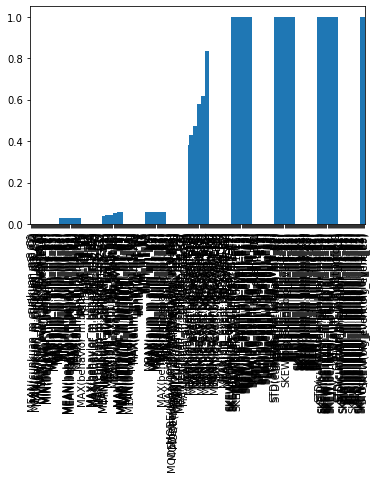

In [17]:
seeWhichColumnsHaveMissingValues(data_train)

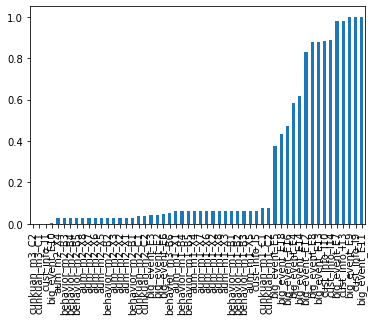

In [16]:
# seeWhichColumnsHaveMissingValues(d4)

In [19]:
def seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, threshold): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > threshold]
    missing.sort_values(inplace=True)
    return list(missing.index)
colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, 0.90)
print(colsThatHaveTooManyNull)

['big_event_E7', 'MIN(big_event.big_event_E7)', 'MAX(big_event.big_event_E7)', 'MEAN(big_event.big_event_E7)', 'cust_info_I13', 'MIN(big_event.big_event_E9)', 'big_event_E9', 'MAX(big_event.big_event_E9)', 'MEAN(big_event.big_event_E9)', 'MEAN(big_event.big_event_E11)', 'MIN(big_event.big_event_E11)', 'MAX(big_event.big_event_E11)', 'SKEW(cunkuan_m.cunkuan_m3_C2)', 'SKEW(cunkuan_m.cunkuan_m3_C1)', 'SKEW(cunkuan_m.cunkuan_m2_C2)', 'SKEW(cunkuan_m.cunkuan_m2_C1)', 'SKEW(cunkuan_m.cunkuan_m1_C2)', 'SKEW(cunkuan_m.cunkuan_m1_C1)', 'STD(cunkuan_m.cunkuan_m3_C2)', 'STD(cunkuan_m.cunkuan_m2_C2)', 'STD(cunkuan_m.cunkuan_m2_C1)', 'STD(cunkuan_m.cunkuan_m1_C2)', 'STD(cunkuan_m.cunkuan_m1_C1)', 'SKEW(behavior_m.behavior_m3_B7)', 'SKEW(behavior_m.behavior_m3_B5)', 'SKEW(behavior_m.behavior_m3_B4)', 'SKEW(behavior_m.behavior_m3_B3)', 'SKEW(behavior_m.behavior_m3_B2)', 'SKEW(behavior_m.behavior_m3_B1)', 'SKEW(behavior_m.behavior_m2_B5)', 'SKEW(behavior_m.behavior_m2_B4)', 'SKEW(behavior_m.behavior_m

上述的列，空值太多(多于90%)，有可能会影响结果，故先放弃。

注意，如果你训练集这样搞了，那么你测试集就得删掉一样的列，不论测试集相应的列有多少空值。

In [20]:
len(data_train.columns)

483

In [21]:
len(data_test_a.columns)

482

In [22]:
data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)

## Classify the features into multiple groups

In [23]:
id_col = ["cust_no"]

In [24]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
object_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'label'
numerical_fea.remove(label)

In [25]:
## 过滤类别较少的和较多的列
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
    
numerical_serial_fea,numerical_categorical_fea = get_numerical_serial_fea(data_train,numerical_fea)
print(numerical_serial_fea)
print(numerical_categorical_fea)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B7', 'big_event_E15', 'big_event_E17', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I11', 'SUM(aum_m.aum_m1_X1)', 'SUM(aum_m.aum_m1_X2)', 'SUM(aum_m.aum_m1_X3)', 'SUM(aum_m.aum_m1_X4)', 'SUM(aum_m.aum_m1_X5)', 'SUM(aum_m.aum_m1_X6)', 'SUM(aum_m.aum_m1_X7)', 'SUM(aum_m.aum_m1_X8)', 'SUM(aum_m.aum_m2_X1)', 'SUM(aum_m.aum

`big_event_E11, cust_info_I7, cust_info_I9` from numerical_categorical_fea, 类别太少，没有意义。

In [26]:
# numerical_categorical_fea.remove("big_event_E11")
numerical_categorical_fea.remove("cust_info_I7")
# numerical_categorical_fea.remove("cust_info_I9")

In [27]:
data_train.drop(["cust_info_I7"], axis = 1, inplace=True)
data_test_a.drop(["cust_info_I7"], axis = 1, inplace=True)

找日期：所有在`object_fea`里面的`big_event_xx`和`behavior_m3_B6` 是时间类型的。

In [28]:
date_fea = []
for fea in object_fea:
    if "big_event" in fea or "behavior" in fea:
        date_fea.append(fea)
print(date_fea)

['behavior_m3_B6', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E4', 'big_event_E5', 'big_event_E6', 'big_event_E8', 'big_event_E10', 'big_event_E12', 'big_event_E13', 'big_event_E14', 'big_event_E16', 'big_event_E18']


找其他类型的列

In [29]:
object_categorical_fea = []
for fea in object_fea:
    if fea not in date_fea and fea not in id_col:
        object_categorical_fea.append(fea)
print(object_categorical_fea)

['cust_info_I1', 'cust_info_I3', 'cust_info_I5', 'cust_info_I8', 'cust_info_I10', 'cust_info_I12', 'cust_info_I14']


In [30]:
total_list = sorted(list(data_train.columns))

In [31]:
id_col

['cust_no']

In [32]:
print(numerical_serial_fea)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B7', 'big_event_E15', 'big_event_E17', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I11', 'SUM(aum_m.aum_m1_X1)', 'SUM(aum_m.aum_m1_X2)', 'SUM(aum_m.aum_m1_X3)', 'SUM(aum_m.aum_m1_X4)', 'SUM(aum_m.aum_m1_X5)', 'SUM(aum_m.aum_m1_X6)', 'SUM(aum_m.aum_m1_X7)', 'SUM(aum_m.aum_m1_X8)', 'SUM(aum_m.aum_m2_X1)', 'SUM(aum_m.aum

In [33]:
print(numerical_categorical_fea)

['cust_info_I4', 'cust_info_I6', 'cust_info_I15', 'cust_info_I16', 'cust_info_I17', 'cust_info_I18', 'cust_info_I19', 'cust_info_I20', 'COUNT(aum_m)', 'MODE(behavior_m.WEEKDAY(behavior_m3_B6))', 'MODE(behavior_m.YEAR(behavior_m3_B6))', 'COUNT(behavior_m)', 'NUM_UNIQUE(behavior_m.DAY(behavior_m3_B6))', 'NUM_UNIQUE(behavior_m.MONTH(behavior_m3_B6))', 'NUM_UNIQUE(behavior_m.WEEKDAY(behavior_m3_B6))', 'NUM_UNIQUE(behavior_m.YEAR(behavior_m3_B6))', 'COUNT(cunkuan_m)', 'SUM(big_event.big_event_E11)', 'COUNT(big_event)']


In [34]:
print(date_fea)

['behavior_m3_B6', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E4', 'big_event_E5', 'big_event_E6', 'big_event_E8', 'big_event_E10', 'big_event_E12', 'big_event_E13', 'big_event_E14', 'big_event_E16', 'big_event_E18']


In [35]:
print(object_categorical_fea)

['cust_info_I1', 'cust_info_I3', 'cust_info_I5', 'cust_info_I8', 'cust_info_I10', 'cust_info_I12', 'cust_info_I14']


`object_categorical_fea` 还能继续分，有的是有等级的，有的没有等级（这些没有等级的，可以考虑进行那个啥，onehot）

下面的代码用来检查有没有特征被漏掉。

In [36]:
new_cates = numerical_categorical_fea + numerical_serial_fea + date_fea + object_categorical_fea 

In [37]:
set(total_list) - set(new_cates)

{'cust_no', 'label'}

如果空留label、ID，则无特征被遗漏。

## Change `object_categorical_fea` 

这里面也有一些类是可以进行序列化的，比如`cust_info_I3`用户的等级, `cust_info_I10`学历, `cust_info_I14`官阶，这几个都可以序列化。

鉴于这个notebook只做最原生态的处理，所以就将之简单归类了。

In [38]:
object_categorical_fea

['cust_info_I1',
 'cust_info_I3',
 'cust_info_I5',
 'cust_info_I8',
 'cust_info_I10',
 'cust_info_I12',
 'cust_info_I14']

对他们进行普通分类，最普通的分类，就是将他们编码为数字。不搞dummy操作。

In [39]:
# cgy = list(data_train.select_dtypes(['object']).columns)

In [40]:
# set(list(cust_info_q3["I10"].unique()) + list(cust_info_q4["I10"].unique()) + list(cust_info_q1["I10"].unique()))

In [41]:
# set(list(cust_info_q3["I14"].unique()) + list(cust_info_q4["I14"].unique()) + list(cust_info_q1["I14"].unique()))

In [42]:
def mapTheValue(data, fea, dic):
    """
    data_train is the dataset. 
    fea is the target feature. 
    dic is the mapping dictionary. 
    """
    data[fea] = data[fea].apply(lambda x: dic.get(x, -1)) 


## 这两个特征，是暗含了顺序
for dt in [data_train, data_test_a]: 
    #### 
    mapTheValue(
        dt, "cust_info_I3", 
        {s : i + 1 for i, s in enumerate(["普通客户", "黄金", '白金', '钻石'])}
    )
    ####
    qte = {s : i + 1 for i, s in enumerate(['文盲或半文盲', '小学教育', '初级中学教育', '技工学校毕业', '中等职业教育', '普通高级中学教育', 
                                          '专科教育', '大学本科', '研究生教育'])}
    qte.update({'未知': np.nan})
    mapTheValue(dt, "cust_info_I10", {
        "普通客户": 0, 
        "黄金": 1,
        "白金": 2,
        "钻石": 3,
    })
    #### 
    qte = {s : i + 1 for i, s in enumerate(['一般员工', 
                                          '中级领导(行政级别局级以下处级以上领导或大公司中级管理人员)', 
                                          '初级领导(行政级别处级以下领导或大公司初级管理人员)', 
                                          '高级领导(行政级别局级及局级以上领导或大公司高级管理人员)'])}
    qte.update({'其他': np.nan})
    mapTheValue(
        dt, "cust_info_I14", ## 职务
        qte,
    )

`cust_info_I3, cust_info_I10, cust_info_I14` 是serial类的哦。以后要从object_categorical_fea里面排除出去。

In [43]:
## 要用，就用所有的str来编码。这里算是一个修正吧。
cust_info_q3 = pd.read_csv('originalDataset/x_train/cust_info_q3.csv')
cust_info_q4 = pd.read_csv('originalDataset/x_train/cust_info_q4.csv')
cust_info_q1 = pd.read_csv('originalDataset/x_test/cust_info_q1.csv')

for col in tqdm.tqdm(
    ## 把尚未编码的cust_info特征进行普通编码
    [fea for fea in list(data_train.select_dtypes(['object']).columns) if "cust_info" in fea] 
): 
    ## 获取最原处的列名，也就是IXX. 
    originColName = col.split("_")[-1]
    le = LabelEncoder()
    le.fit(list(cust_info_q3[originColName].astype(str).values) + list(cust_info_q4[originColName].astype(str).values) + list(cust_info_q1[originColName].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


In [44]:
# data_train.to_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv", index=False)
# data_test_a.to_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv", index=False)

In [45]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv")

## Change `date_fea`


In [46]:
date_fea

['behavior_m3_B6',
 'big_event_E1',
 'big_event_E2',
 'big_event_E3',
 'big_event_E4',
 'big_event_E5',
 'big_event_E6',
 'big_event_E8',
 'big_event_E10',
 'big_event_E12',
 'big_event_E13',
 'big_event_E14',
 'big_event_E16',
 'big_event_E18']

注意，date特征和date_DT类型的特征，在入模之前必须要处理成数字才行。

最普通，直接将日期改为距离新千年第一天多少天。

In [47]:
startdate = datetime.datetime.strptime(
    "2000-01-01 00:00:00",
    '%Y-%m-%d %H:%M:%S'
)
for fea in date_fea:   
# [ "behavior_m3_B6",  
# 'big_event_E1',
#  'big_event_E2',
#  'big_event_E3',
#  'big_event_E6',
#  'big_event_E10']
    print(fea)
    
    data_train[fea] = data_train[fea].astype(str)
    data_test_a[fea] = data_test_a[fea].astype(str)
    
    ## 这里改为与某一固定日期（千禧年第一天）的距离。否则，不同的表格，这些列所得到的数据的标准不一，这样会出事情的。
    if fea in ["behavior_m3_B6"]: ## 这个列有时分秒，不只有日期。
        for data in [data_train, data_test_a]:
            data[fea] = pd.to_datetime(data[fea],format = '%Y-%m-%d %H:%M:%S')
            data[fea] = data[fea].apply(lambda x: x-startdate).dt.days ## 这里或许有潜力可挖，比如，换成秒，分钟啊什么的。
    else: ## 这些列，只有日期。
        for data in [data_train, data_test_a]:
            data[fea] = pd.to_datetime(data[fea],format='%Y-%m-%d')
            data[fea] = data[fea].apply(lambda x: x-startdate).dt.days

behavior_m3_B6
big_event_E1
big_event_E2
big_event_E3
big_event_E4
big_event_E5
big_event_E6
big_event_E8
big_event_E10
big_event_E12
big_event_E13
big_event_E14
big_event_E16
big_event_E18


# Feature Generation

利用 https://zhuanlan.zhihu.com/p/26444240 介绍的方法开展特征合成：

```
median(N1)_by(C1)  \\ 中位数
mean(N1)_by(C1)  \\ 算术平均数
mode(N1)_by(C1)  \\ 众数
min(N1)_by(C1)  \\ 最小值
max(N1)_by(C1)  \\ 最大值
std(N1)_by(C1)  \\ 标准差
var(N1)_by(C1)  \\ 方差
freq(C2)_by(C1)  \\ 频数

freq(C1) \\这个不需要groupby也有意义
```

上述只是一种思路。

## Do something on numerical features. 

对于单个月的统计量

求平均：某月每一个产品平均存款金额

    for i in range(3):
        'cunkuan_m{i}_C1', 某月存款产民金额
        'cunkuan_m{i}_C2', 某月存款产品个数
    
求平均：某月，每一次平均转入多少金额
    
    for i in range(3):
        behavior_m{i}_B2 转账转入次数
        behavior_m{i}_B3 转账转入金额
    
求平均：某月，每一次平均转出多少金额

    for i in range(3):
        'behavior_m{i}_B4', 转账转出次数
        'behavior_m{i}_B5', 转账转出金额

In [48]:
def calculateAvgWithinMonth_cunkuan_c12(data_train):
#     f'cunkuan_m{i}_C1'#, 某月存款产品金额
#     f'cunkuan_m{i}_C2'#, 某月存款产品个数
    newCols = []
    for i in range(1, 3+1):
        data_train[f"cunkuan_m{i}_C1-C2"] = data_train[f'cunkuan_m{i}_C1'] / data_train[f'cunkuan_m{i}_C2']
        newCols.append(f"cunkuan_m{i}_C1-C2")
    return newCols

newCols_data_train = calculateAvgWithinMonth_cunkuan_c12(data_train)
newCols_data_test_a = calculateAvgWithinMonth_cunkuan_c12(data_test_a)

In [49]:
def calculateAvgWithinMonth_behavior_b32(data_train):
#     behavior_m{i}_B2 # 转账转入次数
#     behavior_m{i}_B3 # 转账转入金额
    newCols = []
    for i in range(1, 3+1):
        data_train[f"behavior_m{i}_B3-B2"] = data_train[f'behavior_m{i}_B3'] / data_train[f'behavior_m{i}_B2']
        newCols.append(f"behavior_m{i}_B3-B2")
    return newCols

newCols_data_train = calculateAvgWithinMonth_behavior_b32(data_train)
newCols_data_test_a = calculateAvgWithinMonth_behavior_b32(data_test_a)

In [50]:
def calculateAvgWithinMonth_behavior_b54(data_train):
#     behavior_m{i}_B2 # 转账转入次数
#     behavior_m{i}_B3 # 转账转入金额
    newCols = []
    for i in range(1, 3+1):
        data_train[f"behavior_m{i}_B5-B4"] = data_train[f'behavior_m{i}_B5'] / data_train[f'behavior_m{i}_B4']
        newCols.append(f"behavior_m{i}_B5-B4")
    return newCols

newCols_data_train = calculateAvgWithinMonth_behavior_b54(data_train)
newCols_data_test_a = calculateAvgWithinMonth_behavior_b54(data_test_a)

对于单个的统计量，我们可以计算每一个月的增长率
    
    for i in range(1, 8+1):
        aum_m2_X{i} 相对于 aum_m1_X{i} 增长了多少，
        aum_m3_X{i} 相对于 aum_m2_X{i} 增长了多少，
        aum_m3_X{i} 相对于 aum_m1_X{i} 增长了多少，
        
    for i in range(1, 5 + 1): 
        behavior_m2_B{i} 相对于 behavior_m1_B{i} 增长了多少，
        behavior_m3_B{i} 相对于 behavior_m2_B{i} 增长了多少，
        behavior_m3_B{i} 相对于 behavior_m1_B{i} 增长了多少，
        
    for i in range(1, 2 + 1):
        cunkuan_m2_C{i} 相对于 cunkuan_m1_C{i} 增长了多少，
        cunkuan_m3_C{i} 相对于 cunkuan_m2_C{i} 增长了多少，
        cunkuan_m3_C{i} 相对于 cunkuan_m1_C{i} 增长了多少，

In [51]:
def incrementalRate_aum_m32_m21(data_train):
#     aum_m2_X{i} 相对于 aum_m1_X{i} 增长了多少，
#     aum_m3_X{i} 相对于 aum_m2_X{i} 增长了多少，
    newCols = []
    for i in range(1, 8+1):
        data_train[f"aum_m21_X{i}"] = (data_train[f"aum_m2_X{i}"] - data_train[f"aum_m1_X{i}"]) / data_train[f"aum_m1_X{i}"]
        data_train[f"aum_m32_X{i}"] = (data_train[f"aum_m3_X{i}"] - data_train[f"aum_m2_X{i}"]) / data_train[f"aum_m2_X{i}"]
        newCols.extend([f"aum_m21_X{i}", f"aum_m32_X{i}"])
    return newCols

newCols_data_train = incrementalRate_aum_m32_m21(data_train)
newCols_data_test_a = incrementalRate_aum_m32_m21(data_test_a)

In [52]:
def incrementalRate_behavior_m32_m21(data_train):
#     behavior_m2_B{i} 相对于 behavior_m1_B{i} 增长了多少，
#     behavior_m3_B{i} 相对于 behavior_m2_B{i} 增长了多少，
    newCols = []
    for i in range(1, 5 + 1):
        data_train[f"behavior_m21_B{i}"] = (data_train[f"behavior_m2_B{i}"] - data_train[f"behavior_m1_B{i}"]) / data_train[f"behavior_m1_B{i}"]
        data_train[f"behavior_m32_B{i}"] = (data_train[f"behavior_m3_B{i}"] - data_train[f"behavior_m2_B{i}"]) / data_train[f"behavior_m2_B{i}"]
        newCols.extend([f"behavior_m21_B{i}", f"behavior_m32_B{i}"])
    return newCols

newCols_data_train = incrementalRate_behavior_m32_m21(data_train)
newCols_data_test_a = incrementalRate_behavior_m32_m21(data_test_a)

In [53]:
def incrementalRate_cunkuan_m32_m21(data_train):
#     cunkuan_m2_C{i} 相对于 cunkuan_m1_C{i} 增长了多少，
#     cunkuan_m3_C{i} 相对于 cunkuan_m2_C{i} 增长了多少，
    newCols = []
    for i in range(1, 2 + 1):
        data_train[f"cunkuan_m21_C{i}"] = (data_train[f"cunkuan_m2_C{i}"] - data_train[f"cunkuan_m1_C{i}"]) / data_train[f"cunkuan_m1_C{i}"]
        data_train[f"cunkuan_m32_C{i}"] = (data_train[f"cunkuan_m3_C{i}"] - data_train[f"cunkuan_m2_C{i}"]) / data_train[f"cunkuan_m2_C{i}"]
        newCols.extend([f"cunkuan_m21_C{i}", f"cunkuan_m32_C{i}"])
    return newCols

newCols_data_train = incrementalRate_cunkuan_m32_m21(data_train)
newCols_data_test_a = incrementalRate_cunkuan_m32_m21(data_test_a)

In [54]:
data_train[newCols_data_train].head()

,cunkuan_m21_C1,cunkuan_m32_C1,cunkuan_m21_C2,cunkuan_m32_C2
0,0.232967,1.897814e-01,0.000000,0.000000
1,0.000000,3.084167e-01,0.333333,0.000000
2,0.000000,1.428287e-07,0.000000,0.000000
3,0.000000,-1.907692e-01,0.000000,-0.333333
4,0.000000,1.045058e-02,0.000000,-0.250000


生成了很多空值。就处理一下吧。

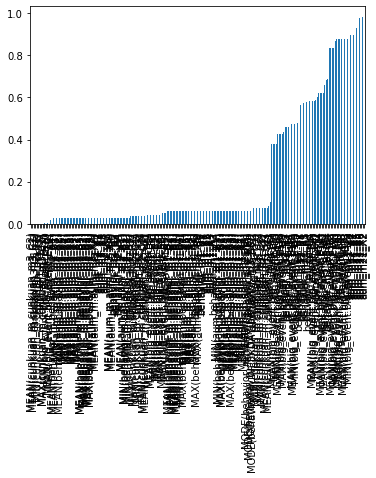

In [55]:
seeWhichColumnsHaveMissingValues(data_train)

In [56]:
colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, 0.90)
print(colsThatHaveTooManyNull)

['aum_m21_X4', 'aum_m32_X5', 'aum_m21_X5', 'aum_m32_X6', 'aum_m21_X6', 'aum_m32_X2', 'aum_m21_X2']


In [57]:
data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)

In [58]:
data_train.shape

(145296, 372)

## Deal with abnormal data ~~~~~~

看看哪一个列具有较多的异常值。

In [59]:
data_train["big_event_E4"].head()

0       NaN
1    6858.0
2       NaN
3       NaN
4    6968.0
Name: big_event_E4, dtype: float64

In [60]:
numerical_serial = [col for col in data_train.columns if col not in ["cust_no", "label", "cust_info_I1", "cust_info_I5", "cust_info_I8", "cust_info_I12"] + numerical_categorical_fea]

In [61]:
print(numerical_serial)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B6', 'behavior_m3_B7', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E4', 'big_event_E5', 'big_event_E6', 'big_event_E8', 'big_event_E10', 'big_event_E12', 'big_event_E13', 'big_event_E14', 'big_event_E15', 'big_event_E16', 'big_event_E17', 'big_event_E18', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I3',

['behavior_m1_B1',
 'behavior_m3_B1',
 'cust_info_I14',
 'SUM(behavior_m.behavior_m1_B1)',
 'SUM(behavior_m.behavior_m3_B1)',
 'MAX(behavior_m.behavior_m1_B1)',
 'MAX(behavior_m.behavior_m3_B1)',
 'MIN(behavior_m.behavior_m1_B1)',
 'MIN(behavior_m.behavior_m3_B1)',
 'MEAN(behavior_m.behavior_m1_B1)',
 'MEAN(behavior_m.behavior_m3_B1)',
 'SUM(big_event.big_event_E2)',
 'SUM(big_event.big_event_E3)',
 'SUM(big_event.big_event_E6)',
 'cunkuan_m21_C2',
 'cunkuan_m32_C2']

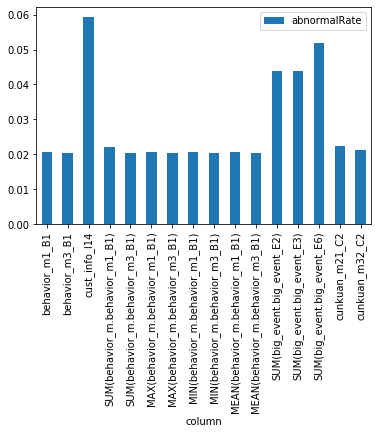

In [62]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

data_train_cp = data_train.copy()
feaList = []
numList = []
for fea in numerical_serial:
    # if fea in ['homeOwnership', 'verificationStatus', "applicationType", "initialListStatus", "policyCode"]:
    #     continue
    data_train_cp = find_outliers_by_3segama(data_train_cp,fea)
    valCount = data_train_cp[fea+'_outliers'].value_counts()
    abnormalRate = 1-valCount["正常值"] / len(data_train_cp)
    if abnormalRate > 0.02:
        feaList.append(fea)
        numList.append(abnormalRate)
        # print(valCount, "\n") ## 获得正常值和异常值的数量
        # print(1-valCount["正常值"] / len(data_train_cp), "\n") ## 获得正常值和异常值的数量
        # print(data_train_cp.groupby(fea+'_outliers')['isDefault'].sum(), "\n") ## 获得异常值和正常值里面有多少个正例
        # print('*'*100)
        
tmpPd = pd.DataFrame({
    "column": feaList, 
    "abnormalRate": numList,
})
tmpPd.set_index(["column"], inplace=True)
tmpPd.plot(kind='bar')
feaList

In [63]:
def chi3(arr):
    '''
    计算卡方值
    arr:频数统计表,二维numpy数组。
    '''
    assert(arr.ndim==2)
    #计算每行总频数
    R_N = arr.sum(axis=1)
    #每列总频数
    C_N = arr.sum(axis=0)
    #总频数
    N = arr.sum()
    # 计算期望频数 C_i * R_j / N。
    E = np.ones(arr.shape)* C_N / N
    E = (E.T * R_N).T
    square = (arr-E)**2 / E
    #期望频数为0时，做除数没有意义，不计入卡方值
    square[E==0] = 0
    #卡方值
    v = square.sum()
    return v

def chiMerge(df,col,target,max_groups=None,threshold=None):

    '''
    卡方分箱
    df: pandas dataframe数据集
    col: 需要分箱的变量名（数值型）
    target: 类标签
    max_groups: 最大分组数。
    threshold: 卡方阈值，如果未指定max_groups，默认使用置信度95%设置threshold。
    return: 包括各组的起始值的列表.
    '''

    freq_tab = pd.crosstab(df[col],df[target])

    #转成numpy数组用于计算。
    freq = freq_tab.values

    #初始分组切分点，每个变量值都是切分点。每组中只包含一个变量值.

    #分组区间是左闭右开的，如cutoffs = [1,2,3]，则表示区间 [1,2) , [2,3) ,[3,3+)。
    cutoffs = freq_tab.index.values

    #如果没有指定最大分组
    if max_groups is None:    
        #如果没有指定卡方阈值，就以95%的置信度（自由度为类数目-1）设定阈值。
        if threshold is None:
            #类数目
            cls_num = freq.shape[-1]
            threshold = chi2.isf(0.05,df= cls_num - 1)

    while True:
        minvalue = None
        minidx = None
        #从第1组开始，依次取两组计算卡方值，并判断是否小于当前最小的卡方
        for i in range(len(freq) - 1):
            v = chi3(freq[i:i+2])
            if minvalue is None or (minvalue > v): #小于当前最小卡方，更新最小值
                minvalue = v
                minidx = i

        #如果最小卡方值小于阈值，则合并最小卡方值的相邻两组，并继续循环
        if  (max_groups is not None and  max_groups< len(freq) ) or (threshold is not None and minvalue < threshold):
            #minidx后一行合并到minidx
            tmp  = freq[minidx] + freq[minidx+1]
            freq[minidx] = tmp
            #删除minidx后一行
            freq = np.delete(freq,minidx+1,0)
            #删除对应的切分点
            cutoffs = np.delete(cutoffs,minidx+1,0)

        else: #最小卡方值不小于阈值，停止合并。
            break
    return cutoffs

def value2group(x,cutoffs):

    '''
    将变量的值转换成相应的组。
    x: 需要转换到分组的值
    cutoffs: 各组的起始值。
    return: x对应的组，如group1。从group1开始。
    '''

    #切分点从小到大排序。
    cutoffs = sorted(cutoffs)
    num_groups = len(cutoffs)

    #异常情况：小于第一组的起始值。这里直接放到第一组。
    #异常值建议在分组之前先处理妥善。
    if x < cutoffs[0]:
        return 1 #'group1'

    for i in range(1,num_groups):
        if cutoffs[i-1] <= x < cutoffs[i]:
            return i # 'group{}'.format(i)

    #最后一组，也可能会包括一些非常大的异常值。
    return num_groups #'group{}'.format(num_groups)

def calWOE(df ,var ,target):

    '''
    计算WOE编码
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：编码字典
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    return gbri['woe'].to_dict()

def calIV(df,var,target):

    '''
    计算IV值
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：IV值
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    gbri['iv'] = (gbri[1] - gbri[0])*gbri['woe']
    return gbri['iv'].sum()

如果是用的Q3的数据，4个列被处理：_______________________ `behavior_m3_B6, cust_info_I14, cunkuan_m21_C2, cunkuan_m32_C2`. 

用Q4的数据的话，`["behavior_m1_B1", "behavior_m3_B1", 'behavior_m3_B6', 'cust_info_I14', 'cunkuan_m21_C2']`

In [64]:
for fea in tqdm.tqdm(feaList): ## ["n0", "n6", "delinquency_2years"]
    try:
        cutoffs = chiMerge(data_train, fea, 'label', max_groups=10)
        data_train[fea] = data_train[fea].apply(value2group,args=(cutoffs,))
        data_test_a[fea] = data_test_a[fea].apply(value2group,args=(cutoffs,))
#         print(f"{fea} is successful.".format(fea))
    except:
        print(f"{fea} is failed.")

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:37<00:00,  6.11s/it]


In [65]:
data_train.shape

(145296, 372)

删掉null太多的列。

In [66]:
while True:
#     seeWhichColumnsHaveMissingValues(data_train)
    colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, 0.90)
    if len(colsThatHaveTooManyNull):
        print(colsThatHaveTooManyNull)
        data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
        data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)
    else:
        break

In [67]:
# data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
# data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)
# data_train.shape

In [68]:
data_train.head()

,cust_no,aum_m1_X1,aum_m1_X2,aum_m1_X3,aum_m1_X4,aum_m1_X5,aum_m1_X6,aum_m1_X7,aum_m1_X8,aum_m2_X1,...,behavior_m21_B3,behavior_m32_B3,behavior_m21_B4,behavior_m32_B4,behavior_m21_B5,behavior_m32_B5,cunkuan_m21_C1,cunkuan_m32_C1,cunkuan_m21_C2,cunkuan_m32_C2
0,0xb2d30bf6,0.0,0.0,15774.75,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.232967,1.897814e-01,4,4
1,0xb2d0c143,110000.0,0.0,20000.30,0.0,0.0,0.0,0.0,0.0,130000.0,...,-0.916851,3.004222,-0.5,0.0,-0.818182,2.0,0.000000,3.084167e-01,6,4
2,0xb2d6004d,70000.0,0.0,13.93,0.0,0.0,0.0,0.0,0.0,70000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.428287e-07,4,4
3,0xb2d5a839,153000.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,153000.0,...,-1.000000,inf,-1.0,inf,-1.000000,inf,0.000000,-1.907692e-01,4,2
4,0xb2d63b24,167000.0,0.0,8.99,0.0,0.0,0.0,0.0,0.0,167000.0,...,NaN,inf,NaN,NaN,NaN,NaN,0.000000,1.045058e-02,4,3


# Last data processing

~~可以再填充一轮na，~~

In [69]:
# x_train.fillna(method='ffill', inplace=True)
# x_test.fillna(method='ffill', inplace=True)

~~然后做一下什么归一化.~~

除了xxxx_categorical_fea，对其他的特征进行归一化。

In [70]:
featuresNeedToBeRegularized = [col for col in data_train.columns if col not in 
     ### 除了 ["cust_info_I3", "cust_info_I10", "cust_info_I14"] 以外的所有categorical的特征，不要。
    [fea for fea in (numerical_categorical_fea + object_categorical_fea) if fea not in ["cust_info_I3", "cust_info_I10", "cust_info_I14"]] 
    ### id，label，不要。
     + ["cust_no", "label"]
]

##[col for col in data_train.columns if col not in ["cust_no", "label", "cust_info_I1", "cust_info_I5", "cust_info_I8", "cust_info_I12"] + numerical_categorical_fea]

In [71]:
data_train[featuresNeedToBeRegularized] = data_train[featuresNeedToBeRegularized].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
data_test_a[featuresNeedToBeRegularized] = data_test_a[featuresNeedToBeRegularized].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

~~特征选择，选取最重要的几个特征~~

In [72]:
# x_train_fill = x_train.fillna(x_train.median())
# x_test_fill = x_test.fillna(x_test.median())
# x_train_fill.shape

# x_new = SelectPercentile(chi2, percentile=90).fit(x_train_fill, y_train)
# newParams = x_new.get_support(True)

# selectedFeatureNames = []
# for i, col in enumerate(list(x_train_fill.columns)):
#     if i in newParams:
#         selectedFeatureNames.append(col)
# len(selectedFeatureNames)

# x_train_selected = x_train[selectedFeatureNames]
# x_test_selected = x_test[selectedFeatureNames]

In [73]:
data_train.shape

(145296, 372)

# Delete the features that will not be used to fit the model

No `xx_outliers` features, no labels, no original dates. 

In [74]:
features = [f for f in data_train.columns if f not in ["cust_no", "label"] and '_outliers' not in f]
y_train = data_train['label'].map({-1: 0, 0: 1, 1: 2})
x_train = data_train[features]
x_test = data_test_a[features]

# Save preprocessed data if necessary

In [75]:
x_train.to_csv("preprocessedData/x_train-3.6-agg.csv", index=False)
x_test.to_csv("preprocessedData/x_test-3.6-agg.csv", index=False)
y_train.to_csv("preprocessedData/y_train-3.6-agg.csv", index=False)

# Load preprocessed data if applicable

In [50]:
x_train = pd.read_csv("preprocessedData/x_train-3.6-agg.csv")
x_test = pd.read_csv("preprocessedData/x_test-3.6-agg.csv")
y_train = pd.read_csv("preprocessedData/y_train-3.6-agg.csv", header=None)

In [ ]:
# x_train_3 = pd.read_csv("preprocessedData/x_train-3.5-q3.csv")
# x_test_3 = pd.read_csv("preprocessedData/x_test-3.5-q3.csv")
# y_train_3 = pd.read_csv("preprocessedData/y_train-3.5-q3.csv", header=None)

# x_train_4 = pd.read_csv("preprocessedData/x_train-3.5.csv")
# x_test_4 = pd.read_csv("preprocessedData/x_test-3.5.csv")
# y_train_4 = pd.read_csv("preprocessedData/y_train-3.5.csv", header=None)

# x_train = pd.concat([x_train_3, x_train_4])
# x_test = pd.concat([x_test_3, x_test_4])
# y_train = pd.concat([y_train_3, y_train_4])

['COUNT(aum_m)', 'MODE(behavior_m.YEAR(behavior_m3_B6))', 'COUNT(behavior_m)', 'SUM(big_event.big_event_E11)', 'COUNT(big_event)']


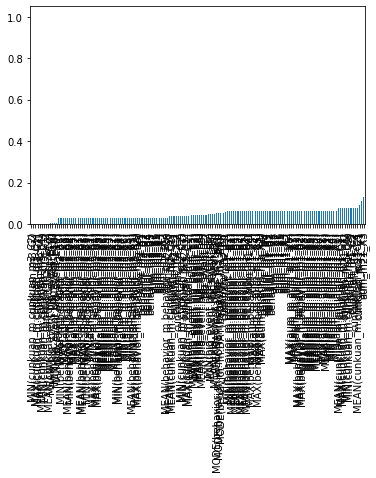

In [61]:
def seeWhichColumnsHaveMissingValues(data_train): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
#     print((missing))
    missing.plot.bar()

def seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, threshold): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > threshold]
    missing.sort_values(inplace=True)
    return list(missing.index)

## 不知道为什么，x_train还有null很多的列。为什么之前那一轮筛查的时候没发现？
while True:
    colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(x_train, 0.90)
    if len(colsThatHaveTooManyNull):
        print(colsThatHaveTooManyNull)
        x_train = x_train.drop(colsThatHaveTooManyNull, axis=1)
        x_test = x_test.drop(colsThatHaveTooManyNull, axis=1)
    else:
        break

In [48]:
# x_train = x_train.head(1000)
# x_test = x_test.head(1000)
# y_train = y_train.head(1000)

# Some hands on model training

In [52]:
testA_result = pd.read_csv('originalDataset/submission_sample.csv')
testA_result_pred = testA_result.copy()

### Scheme A

普通方案. 单个模型. 

似乎啊，不用stratifiedkfold，有的时候效果更好欸。但是如果用的话，会不会更稳呢？
    
    我感觉不会。因为用了StratifiedKFold, 那么拟合出来的模型就适应于原有的label分布，而真实的label分布是怎样的谁知道呢。没有道理认为测试集的数据label分布会和训练集一样。那么，在训练的时候保持训练集的label分布，意义何在？

In [53]:
def getTheFinalVotingResult(l):
    dic = defaultdict(list)
    maxNum = -1
    for i, j in Counter(l).items():
        ## i是l里面的数字，j是i在l出现的次数
        maxNum = max(maxNum, j)
        ## 根据出现次数，来归类i
        dic[j].append(i)
    return random.choice(dic[maxNum])

def kappa_withSklearn_lgb(y_pred, y):
    # print(y_pred.shape)
    index_array = np.argmax(np.reshape(y_pred, (-1, 3)), axis=-1)
    return "Kappa~~", cohen_kappa_score(index_array, y.get_label().astype(int)), True

def kappa_withSklearn_xgb(y_pred, y):
    index_array = np.argmax(y_pred, axis=-1)
    return "Kappa", cohen_kappa_score(index_array, y.get_label().astype(int)) * -1

def kappaMyImplementation(sample_y, sample_pred): 
    ## 我自己实现的kappa 
    ## https://baike.baidu.com/item/kappa%E7%B3%BB%E6%95%B0/9385025
    p0 = accuracy_score(sample_y, sample_pred)
    y_count = Counter(sample_y)
    pred_count = Counter(sample_pred)
    n = len(sample_y)
    s = 0
    for l in [-1, 0, 1]:
        ai = y_count.get(l, 0)
        bi = pred_count.get(l, 0)
        s += ai * bi
    pe = s / (n * n)
    return "Kappa", (p0 - pe) / (1 - pe), True

def cv_model(clf, train_x, train_y, test_x, clf_name, folds = 5):
    # folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    newStackingTestSet = pd.DataFrame(columns=["k{}".format(i + 1) for i in range(folds)])

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'multiclass',
                'num_class': 3,
#                 'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,    
#                 'device_type': 'gpu',
#                 'max_bin': 63
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], 
                              verbose_eval=200, early_stopping_rounds=200, 
                              feval= kappa_withSklearn_lgb,  
                             )
            val_pred_ = model.predict(val_x, num_iteration=model.best_iteration)
            print(val_pred_.shape)
            test_pred_ = model.predict(test_x, num_iteration=model.best_iteration)
            val_pred = np.argmax(val_pred_, axis=-1)
            test_pred = np.argmax(test_pred_, axis=-1)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            params = {
                'booster': 'gbtree',
                'nthread': 36,

                'eta': 0.1, 
                'gamma': 5,
                'max_depth': 10,
                'min_child_weight': 10,
                'subsample': 0.7, 
                "colsample_by": {'colsample_bytree':0.5, 'colsample_bylevel':0.5, 'colsample_bynode':0.5}, ## 曾经是0.7, 0.7
                'lambda': 50,
                'alpha': 10,
                'tree_method': "gpu_hist", #  # 

                'objective': 'multi:softprob',
                "num_class": 3, 
                'seed': 2020,

                "silent": True,
                ###
            }
#             params = {'booster': 'gbtree',
#                       'objective': 'multi:softprob',
#                       "num_class": 3, 
# #                       'eval_metric': 'auc',
#                       'gamma': 1,
#                       'min_child_weight': 1.5,
#                       'max_depth': 5,
#                       'lambda': 10,
#                       'subsample': 0.7,
#                       'colsample_bytree': 0.7,
#                       'colsample_bylevel': 0.7,
#                       'eta': 0.04, 
#                       'seed': 2020,
#                       'nthread': 36,
#                       "silent": True,

#                       'tree_method': "gpu_hist", #  # 
# #                       'tree_method': 'exact',
#                       }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, 
                              evals=watchlist, verbose_eval=200, early_stopping_rounds=200, 
                             feval = kappa_withSklearn_xgb
                             )
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred_  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred_ = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
            val_pred = np.argmax(val_pred_, axis=-1)
            test_pred = np.argmax(test_pred_, axis=-1)
                 
        if clf_name == "cat":
            ## https://catboost.ai/docs/concepts/python-reference_parameters-list.html
            params = {
                'learning_rate': 0.1, 
                'depth': 10, ## 曾经测试过15，但是一旦设置到15，就会奇慢无比
                'l2_leaf_reg': 50, ## 设为20，能够达到40xx的分数。 
                'bootstrap_type': "Bernoulli", ## "Bayesian"比Bernoulli 略强点. 然后我们试试Bernoulli和subsample参数的组合吧。
                # "bagging_temperature": 2, ## 这个参数要跟bayesian bootstrap方法组合起来用。
                "subsample": 0.7, ## 窝槽，bernoulli+subsample加起来很吊啊。。。
                # "sampling_frequency": "PerTree", ## 这个设了没设一样。

                "grow_policy": "Depthwise", ## 这个有奇效。应该还有潜力可挖。
                "min_data_in_leaf": 2, ## 这个也有效果。默认是1，我估计这样搞就太精确了，容易导致过拟合。所以把区间放大一点效果反倒好。
                ## 上面两个，能够达到4236的分数。

                # "grow_policy": "Lossguide", ## grow_policy 很6啊，又有进步。卧槽。还能行不。
                # "min_data_in_leaf": 2, ## 这个也有效果。默认是1，我估计这样搞就太精确了，容易导致过拟合。所以把区间放大一点也可以。
                # "max_leaves": 50, 
                # 上面三个的组合，能够达到4221左右。

                ## 如果要用这个参数，不要弄onehot。都交给catboost吧。
                "one_hot_max_size": 255, ## 能提高一点点。0.0002吧。

                # ## 如果要用这个参数，就要保持原来的datetime列? 搞不懂，照这个试了，不行。估计是因为有nan的原因。
                # "has_time": True,

                ## 设置的大了，性能可能会下降。原档案警告如上。
                "fold_permutation_block": 2, ## 可能有效。可以关注一下。 设为2，达到了4250
                
                ## 对于多分类，应该默认是牛顿法。我们换梯度试试。
                ## 没用。拉垮。
                # "leaf_estimation_method": "Gradient",

                ## 到后期拉垮。
                # "leaf_estimation_iterations": 1,
                # "leaf_estimation_backtracking": "No",

                ## 到后期拉垮。
                # "fold_len_multiplier": 10,

                ## Balanced跑了两次，最高得到了4286的结果。不太稳定。
                "auto_class_weights": "SqrtBalanced",## 得到了4484，升级明显，多测几次，看看是不是偶然 

                ## 这个参数酌情不设吧。因为这个的作用应该跟StratifiedKFold一样吧。
                "allow_const_label": True,

                'od_type': 'Iter', 
                'od_wait': 300, ## 300目前最好。感觉还有潜力，可以进一步挖掘。但是现在先改改别的参数吧。
                
                ## 大于128，也就是默认值，会让成绩稳定在4496左右。酌情设吧。小于默认值是不行的。
                # "border_count": 128, 

                ## MinEntropy和默认值比较好，其他的比较拉垮。
                "feature_border_type": "MinEntropy", 

                # "simple_ctr": 'Buckets',

                ## 以下，我感觉没什么可设的
                'random_seed': 11, 
                'allow_writing_files': False, 
                "task_type": "GPU",
                "eval_metric": "Kappa", 
                # "loss_function": 'MultiClass ', ## 如果用了MultiClass，是3990. 目测用不用这个，效果一致。
            }
            ### 原参数
#             params = {
#                 'learning_rate': 0.05, 
#                 'depth': 5, 
#                 'l2_leaf_reg': 10, 
#                 'bootstrap_type': 'Bernoulli',
#                 'od_type': 'Iter', 
#                 'od_wait': 50, 
#                 'random_seed': 11, 
#                 'allow_writing_files': False, 
#                 "eval_metric": "Kappa", 
# #                 "loss_function": 'MultiClass', 
# #                 "task_type": "GPU",
#             }
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x).ravel()
            test_pred = model.predict(test_x).ravel()
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        # test += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(cohen_kappa_score(val_y, val_pred))
        print(sum(cv_scores)/len(cv_scores), cv_scores)

        newStackingTestSet["k{}".format(i + 1)] = test_pred

    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)

    newStackingTestSet["voteRst"] = newStackingTestSet[list(newStackingTestSet.columns)].apply(getTheFinalVotingResult, axis = 1)
    # print(newStackingTestSet)
    # print(cohen_kappa_score(y_train, train))

    return train, newStackingTestSet, np.mean(cv_scores) # test / kf.n_splits

In [54]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test, lgb_meanPerf = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test, lgb_meanPerf

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test, xgb_meanPerf = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test, xgb_meanPerf

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test, cat_meanPerf = cv_model(CatBoostClassifier, x_train, y_train, x_test, "cat")
    return cat_train, cat_test, cat_meanPerf

In [ ]:
cat_train, cat_test, cat_meanPerf = cat_model(x_train, y_train, x_test)

In [170]:
testA_result_pred["label"] = cat_test.iloc[:,-1]
### 注释掉的两行，酌情运行。
# testA_result_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
# testA_result_pred.fillna(0.0, inplace=True)
testA_result_pred["label"] = testA_result_pred["label"].astype(int)

In [172]:
### 注意###############
## 最后存成文件的时候，要把类别的标签改回-1，0，1.
testA_result_pred["label"] = testA_result_pred["label"].map({0: -1, 1: 0, 2: 1})
testA_result_pred.to_csv("submissionResults/SomeAvgAndIncrementalProportion_ChangeHP-cat-{:.4}.csv".format(cat_meanPerf), index=False) ## 

-------

In [ ]:
## 这个方法目前来看最好，但是最慢。
# xgb_train, xgb_test, xgb_meanPerf= xgb_model(x_train, y_train, x_test)

In [168]:
# testA_result_pred["label"] = xgb_test.iloc[:,-1]
# ### 注释掉的两行，酌情运行。
# testA_result_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
# testA_result_pred.fillna(0.0, inplace=True)
# testA_result_pred["label"] = testA_result_pred["label"].astype(int)

In [169]:
# ### 注意###############
# ## 最后存成文件的时候，要把类别的标签改回-1，0，1.
# testA_result_pred["label"] = testA_result_pred["label"].map({0: -1, 1: 0, 2: 1})
# testA_result_pred.to_csv("submissionResults/SomeAvgAndIncrementalProportion_{:.4}-1.csv".format(xgb_meanPerf), index=False) ## 